# OU process 整理

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

In [33]:
beta=0.7
sigma=1.0
T=10.0
t_target=3.0
dt=5e-3  #時間步長

w=0.55  #mixture
mu1=8.0
s1=1.1
mu2=2.0
s2=0.9

K_traj=32  #trajectories 數量
N_part=6000 #估計pdf形狀的OU粒子數

seed=0
rng = np.random.default_rng(seed)

In [39]:
def sample_gmm(n, w, mu1, s1, mu2, s2, rng):
    u = rng.random(n)
    z1 = rng.normal(mu1, s1, size=n)
    z2 = rng.normal(mu2, s2, size=n)
    return np.where(u < w, z1, z2)

def m_t(t, mu): 
    return np.exp(-beta*t)*mu

def v_t(t, s): 
    return np.exp(-2*beta*t)*s**2 + (sigma**2/(2*beta))*(1-np.exp(-2*beta*t))

def gmm_pdf(y, w, mu1, s1, mu2, s2):   #初始時間的pdf
    n1 = (1.0/np.sqrt(2*np.pi*s1**2))*np.exp(-0.5*((y-mu1)/s1)**2)
    n2 = (1.0/np.sqrt(2*np.pi*s2**2))*np.exp(-0.5*((y-mu2)/s2)**2)
    return w*n1 + (1-w)*n2

def gmm_ou_pdf(y, t):                  #經過OU process之後的mixture pdf
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((y-m1)**2)/v1)
    n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((y-m2)**2)/v2)
    return w*n1 + (1-w)*n2

def gmm_ou_score(x, t):                #反向SDE會用到
    """∇_x log p_t(x) for OU-evolved Gaussian mixture."""
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)
    # component pdf
    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((x-m1)**2)/v1)
    n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((x-m2)**2)/v2)
    denom = w*n1 + (1-w)*n2 + 1e-12
    r1 = (w*n1)/denom     # responsibility for comp1
    r2 = 1.0 - r1
    s1x = -(x - m1)/v1
    s2x = -(x - m2)/v2
    return r1*s1x + r2*s2x

In [46]:
### 畫圖

def plot(traj_hist, times, t_target, w, mu1, s1, mu2, s2):
        # ---- plotting ----
    fig = plt.figure(figsize=(11,2.2))
    gs = GridSpec(nrows=1, ncols=3, width_ratios=[1.2, 10, 1.2], wspace=0.25)
    ax_left  = fig.add_subplot(gs[0,0])
    ax_main  = fig.add_subplot(gs[0,1])
    ax_right = fig.add_subplot(gs[0,2])

    for j in range(traj_hist.shape[1]):
        ax_main.plot(times, traj_hist[:, j], linewidth=1, color="tab:green")
    #ax_main.set_title(mode.replace("_", " ").title())
    ax_main.set_xlabel("$t$")

    ymin = np.min(traj_hist); ymax = np.max(traj_hist)
    pad = 0.2*(ymax - ymin)
    ylims = (ymin - pad, ymax + pad)
    ax_main.set_ylim(*ylims)
    ys = np.linspace(*ylims, 700)

    ax_left.plot(gmm_pdf(ys, w, mu1, s1, mu2, s2), ys, color="C0", linewidth=2)
    ax_left.set_ylim(*ylims); ax_left.set_xlim(left=0)
    ax_left.set_yticks([]); ax_left.set_xlabel("$p_0(x)$", labelpad=6)
    ax_left.spines["top"].set_visible(False); ax_left.spines["right"].set_visible(False)

    ax_right.plot(gmm_ou_pdf(ys, T), ys, color="C0", linewidth=2)
    ax_right.set_ylim(*ylims); ax_right.set_xlim(left=0)
    ax_right.set_yticks([]); ax_right.set_xlabel("$p_T(x)$", labelpad=6)
    ax_right.yaxis.tick_right()
    ax_right.spines["top"].set_visible(False); ax_right.spines["left"].set_visible(False)

    pdf_mid = gmm_ou_pdf(ys, t_target)
    scale = 0.25
    pdf_mid_norm = pdf_mid / pdf_mid.max()
    ax_main.plot(t_target + scale*pdf_mid_norm, ys, color="C0", linewidth=2)
    ax_main.axvline(t_target, color="0.7", linestyle="--", linewidth=1)
    plt.show()


## Ex1: Forward SDE(OU process)

OU Process forward:
$$
dX_t = -\beta X_t dt + \sigma dW_t, \quad X(0)=X_0, \quad \beta,\sigma >0.
$$
  
If $X_0\sim N(0, 1)$, then 
$$
E[X(t)] = 0, \quad \text{Var}[X(t)] = \sigma_t^2 = e^{-2\beta t} + \frac{\sigma^2}{2\beta}\left(1 - e^{-2\beta t}\right).
$$


In [47]:
def SDE_forward(beta, sigma, rng,
                  T, t_target, dt,
                  w, mu1, s1, mu2, s2,
                  K_traj, N_part):
    steps = int(T/dt)
    x = sample_gmm(N_part, w, mu1, s1, mu2, s2, rng)
    times = [0.0]
    traj_hist = [x[:K_traj].copy()]
    t = 0.0
    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        x = x + (-beta*x)*dt + sigma*dW
        t += dt
        if i % int(steps/300) == 0:
            times.append(t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    plot(traj_hist, times, t_target, w, mu1, s1, mu2, s2)

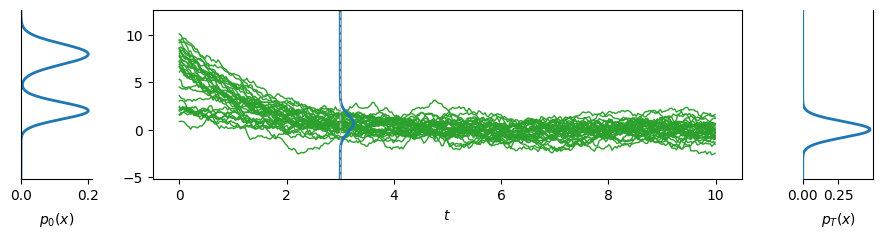

In [48]:
SDE_forward(beta, sigma, rng,
                  T, t_target, dt,
                  w, mu1, s1, mu2, s2,
                  K_traj, N_part)

## EX2: Backward SDE (reverse OU process)

$$
dX_t = \left(-\beta + \frac{\sigma^2}{\sigma^2_t}\right) X_t dt + \sigma dW_t, \quad X_N\sim \mathcal{N}(0, \sigma_T^2).
$$




In [52]:
def simulate_backward_OU(beta, sigma, T, dt,
                         w, mu1, s1, mu2, s2,
                         N_part, K_traj, seed):
    rng = np.random.default_rng(seed)
    steps = int(T/dt)
 
    m1_T, v1_T = m_t(T, mu1), v_t(T, s1)
    m2_T, v2_T = m_t(T, mu2), v_t(T, s2)
    u = rng.random(N_part)
    x1 = rng.normal(m1_T, np.sqrt(v1_T), size=N_part)
    x2 = rng.normal(m2_T, np.sqrt(v2_T), size=N_part)
    x  = np.where(u < w, x1, x2)

    times = [0.0]                 
    traj_hist = [x[:K_traj].copy()]
    
    t=T
    

    s = 0.0                   
    for i in range(1, steps+1):
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        m1_t, v1_t = m_t(t, mu1), v_t(t, s1)
        m2_t, v2_t = m_t(t, mu2), v_t(t, s2)
        mt = w*m1_t + (1-w)*m2_t
        vt = w*v1_t + (1-w)*v2_t
        drift = (-beta*x + (sigma**2)*(x - mt)/vt)
        x = x + drift*(-dt) + sigma*dW
        t += (-1)*dt

        if i % int(steps/300) == 0:
            current_t = T - i*dt
            times.append(current_t)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)
    times = times[::-1]
    traj_hist = traj_hist[::-1, :]

    # 確保 times 從小到大
    idx = np.argsort(times)

    plot(traj_hist, times, t_target, w, mu1, s1, mu2, s2)


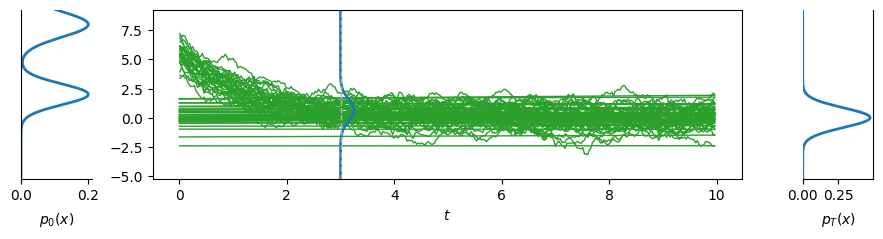

In [53]:
simulate_backward_OU(beta, sigma, T, dt,
                         w, mu1, s1, mu2, s2,
                         N_part, K_traj, seed)

### 解法1: 高斯mixture 的score

In [54]:
def gmm_ou_score2(x, t):
    """True score ∇_x log p_t(x) for OU-evolved 2-Gaussian mixture."""
    m1, v1 = m_t(t, mu1), v_t(t, s1)
    m2, v2 = m_t(t, mu2), v_t(t, s2)

    n1 = (1.0/np.sqrt(2*np.pi*v1))*np.exp(-0.5*((x-m1)**2)/v1)
    n2 = (1.0/np.sqrt(2*np.pi*v2))*np.exp(-0.5*((x-m2)**2)/v2)
    denom = w*n1 + (1-w)*n2 + 1e-12

    r1 = (w*n1)/denom         # responsibility of comp1
    r2 = 1.0 - r1

    s1x = -(x - m1)/v1        # score of comp1
    s2x = -(x - m2)/v2        # score of comp2

    return r1*s1x + r2*s2x


In [57]:
def simulate_backward_OU2(beta, sigma, T, dt,
                         w, mu1, s1, mu2, s2,
                         N_part, K_traj, seed):
    dt=1e-3
    rng = np.random.default_rng(seed)
    steps = int(T/dt)

    # 1. 從 p_T 取樣（兩個 component 演到 T 再混合）
    m1_T, v1_T = m_t(T, mu1), v_t(T, s1)
    m2_T, v2_T = m_t(T, mu2), v_t(T, s2)
    u  = rng.random(N_part)
    x1 = rng.normal(m1_T, np.sqrt(v1_T), size=N_part)
    x2 = rng.normal(m2_T, np.sqrt(v2_T), size=N_part)
    x  = np.where(u < w, x1, x2)

    # 2. 反向 SDE：用 forward-time 參數 s，t = T - s
    times = [T]                 # 真實時間
    traj_hist = [x[:K_traj].copy()]

    s = 0.0
    for i in range(1, steps+1):
        t = T - s               # 對應的真實時間
        dW = rng.normal(0.0, np.sqrt(dt), size=N_part)
        score = gmm_ou_score2(x, t)      # ← 真正的 mixture score
        drift = (-beta*x) - (sigma**2)*score
        x = x + drift*dt + sigma*dW
        s += dt

        if i % int(steps/300) == 0:
            times.append(T - s)
            traj_hist.append(x[:K_traj].copy())

    times = np.array(times)
    traj_hist = np.stack(traj_hist, axis=0)

    # 把時間軸排成遞增（方便畫圖）
    idx = np.argsort(times)
    times = times[idx]
    traj_hist = traj_hist[idx, :]

    # 直接畫
    plot(traj_hist, times, t_target, w, mu1, s1, mu2, s2)


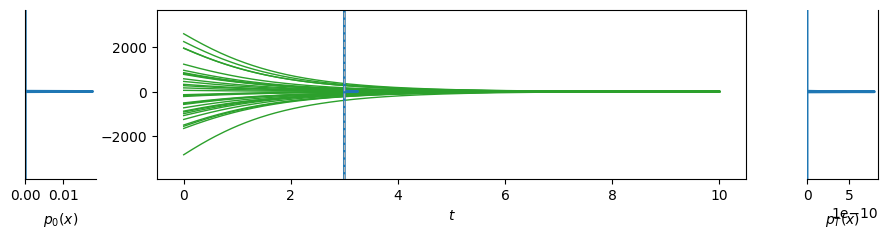

In [58]:
simulate_backward_OU2(beta, sigma, T, dt,
                         w, mu1, s1, mu2, s2,
                         N_part, K_traj, seed)

### 解法2: backward SDE 用 Euler-Maruyama做